# Live-stock detection (DeepForest)
## Context
### Purpose
Implement and finetune a prebuilt Deep Learning model to detect live-stock in airborne imagery.


### Modelling Approach
The [live-stock detection model](https://deepforest.readthedocs.io/en/latest/prebuilt.html#livestock-detectors) from the latest version (v1.4.0) of the [DeepForest](https://deepforest.readthedocs.io/en/latest/) Deep Learning model is used to predict bounding boxes corresponding to cattle from airborn RGB images.

The prebuilt model was trained on a [limited dataset](https://new.wildlabs.net/discussion/global-model-livestock-detection-airborne-imagery-data-applications-and-needs). According to the package's documentation, "the prebuilt models will always be improved by adding data from the target area". As such, this notebook will explore the improvement in the model's performance in live-stock detection from fine-tuning on local data.

### Description
This notebook will explore the capabilities of the DeepForest package. In particular, it will demonstrate how to:

- Detect live-stock in airborne imagery using the prebuilt live-stock detection model.
- Fine-tune the model using a novel publicly-available dataset.
- Evaluate the the model's performance before and after fine-tuning.

### Highlights
The prebuilt model was trained on 2585 training and 808 validation annotations, and its performance metrics on the test set (subset of images excluded from training/validation sets) showed substantial gains:

Box Recall: Improved from 0.4405 to 0.9535.
Box Precision: Improved from 0.5826 to 0.8587.
Mean IoU: Improved from 0.3135 to 0.6571.

### Contributions
#### Notebook
* Cameron Appel (author), Queen Mary University of London, @camappel

#### Modelling codebase
* Ben Weinstein (maintainer & developer), University of Florida, @bw4sz
* Henry Senyondo (support maintainer), University of Florida, @henrykironde
* Ethan White (PI and author), University of Florida, @weecology


## Load libraries
List libraries according to their role e.g. system/files manipulation i.e. os (first), data handling i.e. numpy, xarray (second), visualisation i.e. holoviews (third), etc. The cell below contains two libraries, `os` and `warning` which are common among the Python Jupyter notebooks. Don't remove them.*

In [1]:
!pip -q install torchvision
!pip -q install git+https://github.com/Weecology/DeepForest.git
!pip -q install --upgrade huggingface_hub

In [20]:
import os
import glob
import urllib

import numpy as np
import pandas as pd

import intake
import xmltodict
import cv2
import matplotlib.pyplot as plt

from deepforest import main
from huggingface_hub import hf_hub_download

import torch

from shapely.geometry import box
from skimage.exposure import equalize_hist

import pooch

import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline

## Set project structure
*The cell below creates a separate folder to save the notebook outputs. This facilitates the reader to inspect inputs/outputs stored within a defined destination folder. Don't remove the lines below.*

In [3]:
notebook_folder = './notebook'
if not os.path.exists(notebook_folder):
    os.makedirs(notebook_folder)

In [4]:
extract_dir = os.path.join(notebook_folder, 'test_data')
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir, exist_ok=True)

# Fetch RGB images from Zenodo

Fetch sample images from Harvard's publicly accessible [ODjAR Dataverse](https://dataverse.harvard.edu/dataverse/ODjAR). 

Specifically, G.J. Franke; Sander Mucher, 2021, "Annotated cows in aerial images for use in deep learning models", which includes "a large dataset containing aerial images from fields in Juchowo, Poland and Wageningen, the Netherlands, with annotated cows present in the images using Pascal VOC XML Annotation Format."

In [5]:
unzipped_files = pooch.retrieve(
    url="doi:10.5281/zenodo.13851270/test_data.zip",
    known_hash="6a0a5b48fc9326e97c3cd8bdcabc2bcd131f3755f6ceabbf6976aefbfc87fb00",
    processor=pooch.Unzip(extract_dir=extract_dir),
    path=f"."
)

In [6]:
# Load the CSV (annotations), assuming it's also part of the unzipped files
test_path = [file for file in unzipped_files if file.endswith('test.csv')][0]
test_df = pd.read_csv(test_path)

# Download baseline model

In [7]:
model = main.deepforest()
model.load_model(model_name="weecology/deepforest-livestock", revision="main")

Reading config file: /Users/cam/miniconda3/envs/deepforest/lib/python3.10/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Reading config file: /Users/cam/miniconda3/envs/deepforest/lib/python3.10/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


deepforest(
  (model): RetinaNet(
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): FrozenBatchNorm2d(256, eps=0.0)
            (relu): ReLU(inplace=True)
            (downsample): Sequential(
              (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias

# Evaluate baseline performance

In [8]:
model.label_dict = {'cow': 0}  # Assign a unique integer ID to the 'cow' label
model.config['gpus'] = '-1'  # Use GPU (set to '0' for the first GPU or '-1' for all GPUs)

# Set the directory to save the results of the pretrained model
baseline_save_dir = os.path.join(notebook_folder, 'baseline_pred_result')
os.makedirs(baseline_save_dir, exist_ok=True)

# Evaluate the pretrained model on the test set (using test_file)
baseline_results = model.evaluate(test_path, os.path.dirname(test_path), iou_threshold=0.4, savedir=baseline_save_dir)

print("Baseline evaluation complete. Results saved to", baseline_save_dir)

Predicting: |                                                                                                 …

/Users/cam/miniconda3/envs/deepforest/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Baseline evaluation complete. Results saved to ./notebook/baseline_pred_result


In [9]:
print("Baseline performance")
# Print box recall and precision with clean formatting
print(f"Box Recall: {baseline_results['box_recall']:.4f}")
print(f"Box Precision: {baseline_results['box_precision']:.4f}")

# Compute and print the mean IoU, rounded to 4 decimal places
mean_iou = np.mean(baseline_results['results']['IoU'])
print(f"Mean IoU: {mean_iou:.4f}")

Baseline performance
Box Recall: 0.4405
Box Precision: 0.5826
Mean IoU: 0.3135


# Visualise

## Load sample image

In [32]:
import pandas as pd
import os
from PIL import Image
from deepforest.visualize import plot_predictions
import matplotlib.pyplot as plt

# Step 1: Load the test.csv file
test_csv_path = os.path.join(extract_dir, "test.csv")
df = pd.read_csv(test_csv_path)

# Step 2: Load the image
image_name = "20181001 (88).JPG"  # The image you want to plot, change this as needed
image_path = os.path.join(extract_dir, image_name)
image = Image.open(image_path)

# Convert the image to a numpy array
image_np = np.array(image)

## Plot ground truth

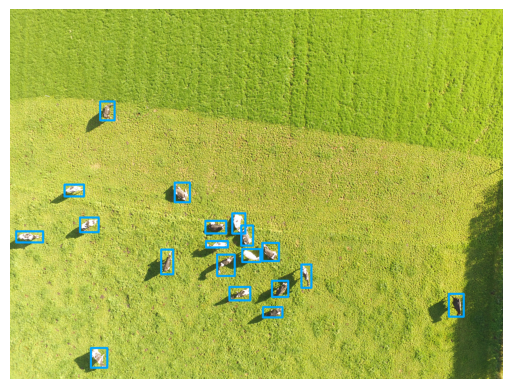

In [40]:
# Step 3: Filter bounding boxes for the specific image
image_boxes = df[df['image_path'] == image_name]

# Step 4: Prepare bounding boxes DataFrame for plot_predictions
boxes_df = image_boxes[['xmin', 'xmax', 'ymin', 'ymax', 'label']]

# Step 5: Plot bounding boxes on the image using deepforest.visualize
annotated_image_truth = plot_predictions(image_np, boxes_df, color=(0, 165, 255), thickness=15)

# Step 6: Display the image with bounding boxes
plt.imshow(annotated_image_truth)
plt.axis('off')  # Turn off axis to focus on the image
plt.show()

## Plot prediction

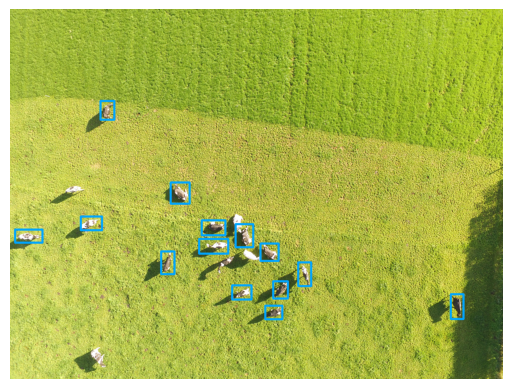

In [42]:
# Assuming baseline_results is already available
predictions_df = baseline_results['predictions']

# Step 2: Filter predicted boxes for the specific image
image_predictions = predictions_df[predictions_df['image_path'] == image_name]

# Step 3: Prepare bounding boxes DataFrame for plot_predictions
# Use xmin, ymin, xmax, ymax and label columns from predictions
boxes_df = image_predictions[['xmin', 'xmax', 'ymin', 'ymax', 'label']]

# Step 4: Plot bounding boxes on the image using deepforest.visualize
annotated_image_base = plot_predictions(image_np, boxes_df, color=(0, 165, 255), thickness=15)

# Step 5: Display the image with bounding boxes
plt.imshow(annotated_image_base)
plt.axis('off')  # Turn off axis to focus on the image
plt.show()

# Train model
We then trained the model and uploaded to HuggingFace using the following code:

```python
import pytorch_lightning as pl

output_dir = os.path.join(notebook_folder, 'data')
test_dir = os.path.join(notebook_folder, 'test_data')

train_file = os.path.join(output_dir, "train.csv")
valid_file = os.path.join(output_dir, "valid.csv")
test_file = os.path.join(test_dir, "test.csv")

model.label_dict = {'cow': 0}  # Rename label

# Configure the model for GPU usage and set the CSV file paths
model.config['gpus'] = '-1'  # Use GPU (set to '0' for the first GPU or '-1' for all GPUs)
model.config["train"]["csv_file"] = train_file  # Path to training CSV
model.config["train"]["root_dir"] = os.path.dirname(train_file)  # Root directory for training images
model.config["score_thresh"] = 0.4  # Set score threshold
model.config["train"]['epochs'] = 5  # Number of epochs
model.config["validation"]["csv_file"] = valid_file  # Path to validation CSV
model.config["validation"]["root_dir"] = os.path.dirname(valid_file)  # Root directory for validation images

model.create_trainer()
model.trainer.fit(model)

checkpoint_dir = './drive/MyDrive/notebook/checkpoints_ckpt'
os.makedirs(checkpoint_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Save the model checkpoint as .ckpt
checkpoint_path = "{}/finetuned_checkpoint.ckpt".format(checkpoint_dir)

# Save the checkpoint after training using PyTorch Lightning's save_checkpoint method
model.trainer.save_checkpoint(checkpoint_path)
```

# Load finetuned model

In [35]:
# Download the finetuned model checkpoint from Hugging Face
ckpt_path = hf_hub_download(
    repo_id="camappel/deepforest-livestock",  # Replace with your Hugging Face repo ID
    filename="finetuned_checkpoint.ckpt"     # The .ckpt file you uploaded
)

# Load the model checkpoint correctly using the class, not an instance
model = main.deepforest.load_from_checkpoint(ckpt_path)

print("Finetuned model loaded successfully!")

Reading config file: /Users/cam/miniconda3/envs/deepforest/lib/python3.10/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finetuned model loaded successfully!


# Evaluate finetuned performance

In [36]:
model.label_dict = {'cow': 0}  # Assign a unique integer ID to the 'cow' label
model.config['gpus'] = '-1'  # Use GPU (set to '0' for the first GPU or '-1' for all GPUs)


# Set the directory to save the results of the pretrained model
finetuned_save_dir = os.path.join(notebook_folder, 'finetuned_pred_result')
os.makedirs(finetuned_save_dir, exist_ok=True)

# Evaluate the pretrained model on the test set (using test_file)
finetuned_results = model.evaluate(test_path, os.path.dirname(test_path), iou_threshold=0.4, savedir=finetuned_save_dir)

print("Finetuned evaluation complete. Results saved to", finetuned_save_dir)

Predicting: |                                                                                                 …

/Users/cam/miniconda3/envs/deepforest/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Finetuned evaluation complete. Results saved to ./notebook/finetuned_pred_result


In [37]:
print("Finetuned performance")
# Print box recall and precision with clean formatting
print(f"Box Recall: {finetuned_results['box_recall']:.4f}")
print(f"Box Precision: {finetuned_results['box_precision']:.4f}")

# Compute and print the mean IoU, rounded to 4 decimal places
mean_iou = np.mean(finetuned_results['results']['IoU'])
print(f"Mean IoU: {mean_iou:.4f}")

Finetuned performance
Box Recall: 0.9535
Box Precision: 0.8587
Mean IoU: 0.6571


# Visualise

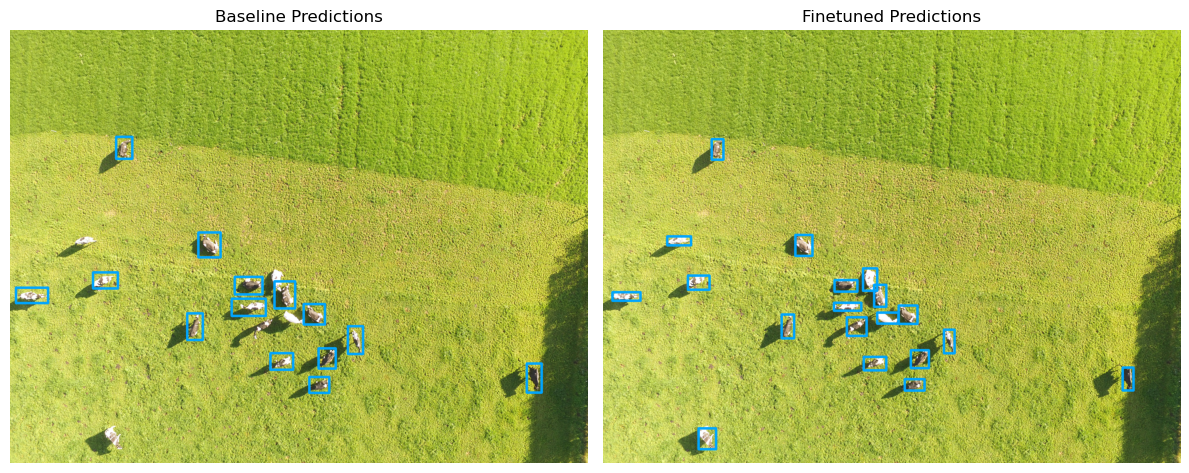

In [43]:
# Assuming baseline_results is already available
predictions_df = finetuned_results['predictions']

# Step 2: Filter predicted boxes for the specific image
image_predictions = predictions_df[predictions_df['image_path'] == image_name]

# Step 3: Prepare bounding boxes DataFrame for plot_predictions
# Use xmin, ymin, xmax, ymax and label columns from predictions
boxes_df = image_predictions[['xmin', 'xmax', 'ymin', 'ymax', 'label']]

# Step 4: Plot bounding boxes on the image using deepforest.visualize
annotated_image_fine = plot_predictions(image_np, boxes_df, color=(0, 165, 255), thickness=15)

# Step 5: Display the image with bounding boxes
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create 1 row, 2 column layout

# Plot ground truth on the left
axs[0].imshow(annotated_image_base)
axs[0].set_title("Baseline Predictions")
axs[0].axis('off')  # Turn off axis for clarity

# Plot predictions on the right
axs[1].imshow(annotated_image_fine)
axs[1].set_title("Finetuned Predictions")
axs[1].axis('off')  # Turn off axis for clarity

# Show the side-by-side plots
plt.tight_layout()
plt.show()

## Summary

This notebook demonstrates how to finetune the DeepForest livestock detection model, with significant performance improvements after fine-tuning for 5 epochs. The model was trained on labelled aerial images of cows from Dataverse (2585 training/808 validation), and its performance metrics on the test set (subset of images excluded from training/validation sets) showed substantial gains:

Box Recall: Improved from 0.4405 to 0.9535.
Box Precision: Improved from 0.5826 to 0.8587.
Mean IoU: Improved from 0.3135 to 0.6571.

## Additional information
**Dataset**: Type here details of dataset(s) version.

**Codebase**: Type here details of codebase version (only for notebooks categorised under modelling/preprocesing/post-processing themes).

**License**: The code in this notebook is licensed under the MIT License. The Environmental Data Science book is licensed under the Creative Commons by Attribution 4.0 license. See further details [here](https://github.com/alan-turing-institute/environmental-ds-book/blob/master/LICENSE.md).

**Contact**: If you have any suggestion or report an issue with this notebook, feel free to [create an issue](https://github.com/alan-turing-institute/environmental-ds-book/issues/new/choose) or send a direct message to [environmental.ds.book@gmail.com](mailto:environmental.ds.book@gmail.com).

In [ ]:
from datetime import date
print(f'Last tested: {date.today()}')